Note:   
 This project is to show what Neural Network training looks like under the hood.
 We will be building micrograd from andrej karpathy's micrograd project.    
 Micrograd is a tiny autograd(automatic gradient) engine and neural network library written in Python.  
 what it does is it implments backpropagation - backpropagation is the algorithm that allows you to efficiently compute the gradients of a loss function with respect to the weight of a neural network.    
 This allows us to iteratively tune the weight of the neural network to minimize the loss function and improve the accuracy of the network

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

Text(0.5, 1.0, 'Plot of f(x) = 3x^2 - 4x + 5')

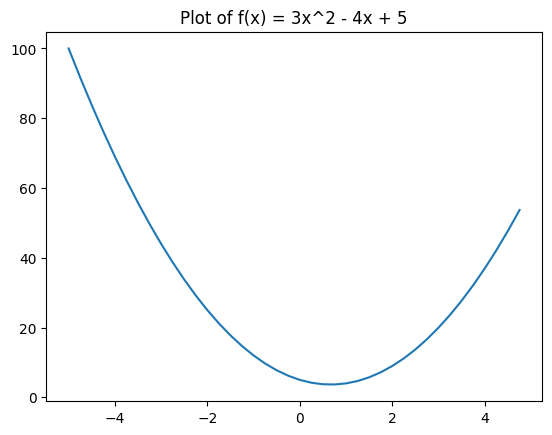

In [4]:
# to see the shape of the fuction f(x)   - f of x\n
xs = np.arange(-5, 5, 0.25) #values from -5 to 5 in steps of 0.25
ys = f(xs) #compute f(x) for each value in xs
plt.plot(xs, ys) #plot the points
plt.title("Plot of f(x) = 3x^2 - 4x + 5")

Derivative is basically if you add or reduce one number, does the other respond positively or negatively to it and how deep is the effect (the slope of the function).

In [5]:
# the derivative mathemathically
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h #mathematical derivative formula

2.999378523327323e-06

In [6]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
# to track the impact of the changes
h = 0.0001

# inputs 
a = 2.0
b = -3.0
c = 10.0

d1 = a *b +c
a +=h  #can either be a, b or c to see the changes effect
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d1 - d2)/h)

d1 4.0
d2 3.999699999999999
slope 3.000000000010772


In [8]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self.grad = 0.0 #represent the derivative of the output with respect to that value
        self._prev =set(_children) #enable us track what two values were added/mul to get another value
        self._op = _op #enable us track what operation created a value
        self.label = label #enable us know what variable has what value during visualization

    def __repr__(self): #better readability for output result
        return f"Value(data={self.data})"
    
    def __add__(self, other): #how to manually add two object
        out = Value(self.data + other.data, (self, other), "+" ) #a.__add__(b) - what the function does, (self, other) - is the "children" of the value but it should have been named parent since the two values make up the output value
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*") #a.__mul__(b)
        return out
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e" #a.__mul__(b)
d = e +c; d.label="d" #e.__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label = "L" #we are using this to represent the Loss function in this context
L


Value(data=-8.0)

if you are runing the jupter notebook on your vs code like i am, you need both the pip installed graphviz and the brew install graphviz for it to work;
self.grad = 0.0 #represent the derivative of the output (e,d,L) with respect to that value - i.e grad in variable d, is the derivative of L with respect to d, grad in variable b, is the derivative of e with respect to b.


In [9]:
# function to help us visualize the expressions
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graphs
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


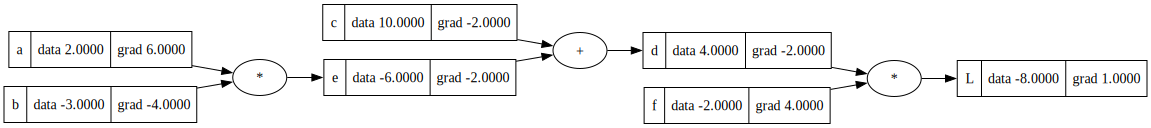

In [13]:
draw_dot(L) 

var a;
var b;
var c;
e = a * b;
d = e + c;
var f;
L = d * f;  
L represent the loss function, which represents the result of all the operations carried out on the inputs;
The process of the operations carried out on the inputs to get L is known as the forward pass;
Back-propagation is the reverse of forward pass;  
Back-prop involves calculating the gradient along all the intermidate values that was added to get L;
For every single value, we will compute the derivative of that value with respect to L;
i.e, derivative of L with respect to L (it's 1), derivative of L with respect to f, derivative of L with respect to e - same for a,b,c and d;
In neural netowrk (NN) settings, we are concerned with the derivative of L (loss function) with respect to some of its leaf nodes (c,d,e,f) which will become the weights of the NN, while the rest nodes will be the data itself (a,b);
Usually we will not want/use the derivative of the loss fuction (L) with respect to the data, because the data is fixed but the weights will be iterated on;

In [ ]:
L.grad = 1.0 #( dL/dL = 1) always true 
d.grad = L.grad * f.data
f.grad = L.grad * d.data

c.grad = d.grad * 1.0
e.grad = d.grad * 1.0

a.grad = c.grad * b.data 
b.grad = c.grad * a.data

In [12]:
def lol():
    h = 0.001
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e" 
    d = e +c; d.label="d" 
    f = Value(-2.0, label='f')
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e" 
    d = e +c; d.label="d" 
    f = Value(-2.0, label='f')
    L = d * f; L.label = "L"
    L2 = L.data
    print((L2 - L1)/h) #this will give us the derivative(grad) of L with respect to 'a'
lol()

6.000000000000227


how to use the above code to manually solve for the derivative(gradient) of each variable using h;
L2 = L.data + h #this will give the derivative(grad) of L with respect to 'L';
a = Value(2.0 + h, label="a") #this will give the derivative(grad) of L with respect to 'a';
b = Value(-3.0 + h, label="b") #this will give the derivative(grad) of L with respect to 'b';
f = Value(-2.0, label='f') #this will give the derivative(grad) of L with respect to 'f';
d = e + c; d.label="d" 
d = d.data + h  #this will give the derivative(grad) of L with respect to 'd';

#we are basically adding h to the L2 section of the variable that we want the grad
